In [6]:
import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback, TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import random

import os
import numpy as np
from scipy import signal

from keras import layers, models, regularizers

from tensorflow.keras import layers, models, regularizers

def create_model(config):
    kernel_size = config['kernel_size']
    regularizer = regularizers.l2(config['reg'])
    dropout_rate = config['dropout']
    size_0 = config['start_filters']

    # Input layer
    in_data = layers.Input(shape=(config['input_size'], 1))

    # Encoder part
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(in_data)
    conv0 = layers.BatchNormalization()(conv0)
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
    conv0 = layers.BatchNormalization()(conv0)
    pool0 = layers.MaxPooling1D(pool_size=2)(conv0)

    size_1 = size_0 * 2
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool0)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    size_2 = size_1 * 2
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Decoder part
    up1 = layers.UpSampling1D(size=2)(conv2)
    up_conv1 = layers.Conv1D(size_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up_conv1 = layers.BatchNormalization()(up_conv1)
    merge1 = layers.concatenate([conv1, up_conv1], axis=2)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)

    up2 = layers.UpSampling1D(size=2)(conv3)
    up_conv2 = layers.Conv1D(size_1, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    up_conv2 = layers.BatchNormalization()(up_conv2)
    merge2 = layers.concatenate([conv0, up_conv2], axis=2)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Output layer
    #out_data = layers.Conv1D(1, kernel_size, activation='sigmoid', padding='same')(conv4)
    out_data = layers.Conv1D(1, kernel_size, activation=None, padding='same')(conv4)

    model = models.Model(inputs=[in_data], outputs=[out_data])
    model.summary()

    return model


def load_data():
     # bidmc
    path = "/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/data/bidmc-ppg-and-respiration-dataset-1.0.0"
    EXT = "*Signals.csv"
    all_csv_files = [file for path, subdir, files in os.walk(path) for file in glob(os.path.join(path, EXT))]
    patients = []
    data = {}
    no_errors = 0
    for file in all_csv_files:
        try:
            df = pd.read_csv(file)
            X1, X2, X3, X4 = df[' PLETH'].values, df[' V'].values, df[' AVR'].values, df[' II'].values
            # X = np.concatenate([X1.reshape(len(X1),1),X2.reshape(len(X1),1),X3.reshape(len(X1),1),X4.reshape(len(X1),1)], axis=1)
            
            Y = df[' RESP'].values
            
            patient = int(file.split('/')[-1].split('_')[1])
            patients.append(patient)
            #data[patient] = [X4, Y]
            data[patient] = np.array([X4, Y])
        except:
            no_errors += 1

    return data, patients

def load_fantasia():
    files = os.listdir("/Users/lanacaldarevic/workspace/phd/biosignal_deeplearning/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/Users/lanacaldarevic/workspace/phd/biosignal_deeplearning/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([data["ECG"], data["RESP"]])

    return data_fantasia, patients_fantasia

import io
class VisualiseCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, frequency=20):
        super(VisualiseCallback, self).__init__()
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Ground truth vs. Prediction')
    
            for row in range(2):
                train_idx = np.random.randint(0, windows_ecg_train.shape[0])
                val_idx = np.random.randint(0, windows_ecg_validation.shape[0])
    
                to_predict_train = np.array([windows_ecg_train[train_idx]])
                ground_truth_train = windows_resp_train[train_idx]
                prediction_train = self.model.predict(to_predict_train)[0]
                prediction_train_score = self.model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)
    
                to_predict_validation = np.array([windows_ecg_validation[val_idx]])
                ground_truth_validation = windows_resp_validation[val_idx]
                prediction_validation = self.model.predict(to_predict_validation)[0]
                prediction_validation_score = self.model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)
    
                ax[row, 0].plot(ground_truth_train, label='Ground Truth')
                ax[row, 0].plot(prediction_train, label='Prediction')
                ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f} CC: {prediction_train_score[1]:.4f}")
                ax[row, 0].legend()
    
                ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
                ax[row, 1].plot(prediction_validation, label='Prediction')
                ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f} CC: {prediction_validation_score[1]:.4f}")
                ax[row, 1].legend()
    
            plt.tight_layout()
            # Convert the matplotlib plot to a PNG image and then to a Tensor
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(fig)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
    
            # Log the image to TensorBoard
            with self.writer.as_default():
                tf.summary.image("Predictions vs. Ground Truth", image, step=epoch)
    
            self.writer.flush()




In [7]:
import wfdb
data, patients = load_fantasia()

In [8]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                normalized_ecg = (recrd_ecg - recrd_ecg.min()) / (recrd_ecg.max() - recrd_ecg.min())
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))

    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [9]:
import wfdb

def load_record(participant, data_dir):
    if isinstance(participant, bytes):
        participant = participant.decode('utf-8')
    if isinstance(data_dir, bytes):
        data_dir = data_dir.decode('utf-8')

    data, info = wfdb.rdsamp(os.path.join(data_dir, participant))
    
    data = pd.DataFrame(data, columns=info["sig_name"])
    
    return [data["ECG"], data["RESP"]]

"""
def resample_and_normalize(ecg, resp, downsampled_window_size):
    # Normalize and resample the signals
    ecg_min, ecg_max = np.min(ecg), np.max(ecg)
    ecg = (ecg - ecg_min) / (ecg_max - ecg_min)
    ecg = signal.resample(ecg, downsampled_window_size)
    
    resp_min, resp_max = np.min(resp), np.max(resp)
    resp = (resp - resp_min) / (resp_max - resp_min)
    resp = signal.resample(resp, downsampled_window_size)

    return ecg.astype(np.float32), resp.astype(np.float32)

def tf_resample_and_normalize(ecg, resp, downsampled_window_size):
    # Wrap the scipy resample operation in a TensorFlow op
    ecg, resp = tf.numpy_function(
        resample_and_normalize, 
        [ecg, resp, downsampled_window_size], 
        [tf.float32, tf.float32]
    )
    # Reshape the signals to ensure the shape is correctly defined
    ecg.set_shape([downsampled_window_size])
    resp.set_shape([downsampled_window_size])
    return ecg, resp

def create_windows(ecg, resp, window_size, overlap):
    # Split the signals into windows
    stride = int(window_size * overlap)
    num_windows = (tf.size(ecg) - window_size) // stride
    ecg_windows = tf.signal.frame(ecg, window_size, stride)
    resp_windows = tf.signal.frame(resp, window_size, stride)
    return ecg_windows, resp_windows
"""

def normalize_and_resample(signal, downsampled_window_size):
    """Normalizes and resamples a given signal."""
    signal_min = tf.reduce_min(signal)
    signal_max = tf.reduce_max(signal)
    normalized_signal = (signal - signal_min) / (signal_max - signal_min)
    # Use scipy's resample method through tf.numpy_function
    resampled_signal = tf.numpy_function(signal.resample, [normalized_signal, downsampled_window_size], tf.float32)
    resampled_signal.set_shape([downsampled_window_size])
    return resampled_signal

def process_signal_windows(ecg_windows, resp_windows, downsampled_window_size):
    """Processes windows of ECG and RESP signals by normalizing and resampling them."""
    valid_ecg_indices = tf.where(tf.reduce_max(ecg_windows, axis=1) > tf.reduce_min(ecg_windows, axis=1))
    valid_resp_indices = tf.where(tf.reduce_max(resp_windows, axis=1) > tf.reduce_min(resp_windows, axis=1))
    
    # Filter valid indices for both ECG and RESP
    valid_indices = tf.sets.intersection(valid_ecg_indices, valid_resp_indices)
    valid_indices = tf.sparse.to_dense(valid_indices)

    ecg_windows = tf.gather(ecg_windows, valid_indices)
    resp_windows = tf.gather(resp_windows, valid_indices)

    ecg_processed = tf.map_fn(lambda x: normalize_and_resample(x, downsampled_window_size), ecg_windows, dtype=tf.float32)
    resp_processed = tf.map_fn(lambda x: normalize_and_resample(x, downsampled_window_size), resp_windows, dtype=tf.float32)

    return ecg_processed, resp_processed

def create_windows_and_process(data, window_size, overlap, downsampled_window_size):
    """Creates windows and processes ECG and RESP signals from data."""
    ecg, resp = data[:, 0], data[:, 1]
    stride = int(window_size * overlap)
    ecg_windows = tf.signal.frame(ecg, window_size, stride)
    resp_windows = tf.signal.frame(resp, window_size, stride)

    return process_signal_windows(ecg_windows, resp_windows, downsampled_window_size)

def create_dataset(patient_indices, data_dir, window_size, downsampled_window_size, overlap):
    patient_ds = tf.data.Dataset.from_tensor_slices(patient_indices)

    # Load and process data
    dataset = patient_ds.map(
        lambda p: tf.numpy_function(
            func=load_record,
            inp=[p, data_dir],
            Tout=[tf.float64, tf.float64]
        ),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    # Apply windowing and further processing
    dataset = dataset.map(
        lambda data: create_windows_and_process(data, window_size, overlap, downsampled_window_size),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    return dataset


data_dir = "/Users/lanacaldarevic/workspace/phd/biosignal_deeplearning/fantasia-database-1.0.0/"
files = os.listdir(data_dir)
files = [s.replace('.dat', '') for s in files if ".dat" in s]
patients_fantasia = []   
    
for i, participant in enumerate(files):
    patients_fantasia.append(participant)

In [10]:
from tensorboard.plugins.hparams import api as hp
import uuid
import datetime


def train(config):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    hp_part = '_'.join(f"{k}-{str(v)}" for k, v in config.items())
    log_dir = f"logs/hparam_tuning/{timestamp}_{hp_part}"
    
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, update_freq='epoch')

    # Log the hyperparameters using TensorBoard
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(config)  # log the values of the hyperparameters
        # Continue with training after this

    # Your optimizer, model creation, and callbacks configuration
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

    # Assuming you have a function to create your model
    model = create_model(config)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    filepath = os.path.join('models', f'model_crossval-size{config["start_filters"]}-input{config["input_size"]}-lr{config["learning_rate"]}-kernel{config["kernel_size"]}-reg{config["reg"]}-dropout{config["dropout"]}.h5')

    visualize_callback = VisualiseCallback(log_dir=log_dir)
    callbacks = [
        ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tensorboard_callback,
        visualize_callback
    ]

    # Start training
    model.fit(
        windows_ecg_train, windows_resp_train,
        epochs=200,
        batch_size=config['batch_size'],
        validation_data=(windows_ecg_validation, windows_resp_validation),
        callbacks=callbacks
    )

    model.save(os.path.join('models',
                            f'combined_model-size{config["start_filters"]}-input{config["input_size"]}-lr{config["learning_rate"]}-kernel{config["kernel_size"]}-reg{config["reg"]}-dropout{config["dropout"]}.h5'))

    return model

(44274, 1024, 1)
(44274, 1024, 1)
(12430, 1024, 1)
(12430, 1024, 1)


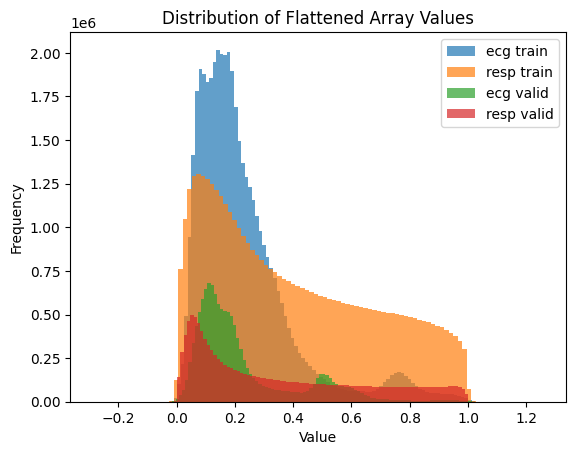

GPU enabled


2024-05-06 14:48:10.343713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-06 14:48:10.344043: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-06 14:48:10.344059: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-06 14:48:10.344206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-06 14:48:10.344252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
import itertools
hparams = {
    'learning_rate': hp.HParam('learning_rate', hp.RealInterval(0.0001, 0.1)),
    'start_filters': hp.HParam('start_filters', hp.Discrete([8])),
    'input_size': hp.HParam('input_size', hp.Discrete([1024])),
    'kernel_size': hp.HParam('kernel_size', hp.Discrete([27])),
    'reg': hp.HParam('reg', hp.RealInterval(0.00001, 0.01)),
    'dropout': hp.HParam('dropout', hp.RealInterval(0.1, 0.5)),
    'batch_size': hp.HParam('batch_size', hp.Discrete([256])),
    #'split_ind': hp.HParam('split_ind', hp.Discrete([0, 1, 2, 3, 4]))
}

# Define a function to create hyperparameter configurations
def generate_hparam_configurations(hparams):
    keys, values = zip(*[(k, list(v.domain.values)) if isinstance(v.domain, hp.Discrete) else (k, [v.domain.min_value, v.domain.max_value]) for k, v in hparams.items()])
    print(values)
    for v in itertools.product(*values):
        yield dict(zip(keys, v))

# Training function
def train_model_for_hparams(hparam_config):
    config = {k: v for k, v in hparam_config.items()}
    model = train(config)
    print(f"Trained with config: {config}")
    return model

downsampled_window_size = 1024
window_size=int(downsampled_window_size*1.953125)
train_ind = []
val_ind = []
batch_size = 256

train_val_patients, test_patients = train_test_split(patients, test_size=0.20, random_state=42)
train_val_patients_array = np.array(train_val_patients)

k = 5
kf = KFold(n_splits=k)

# Now you can perform indexing
for train_index, val_index in kf.split(train_val_patients_array):
    train_ind.append(train_index)
    val_ind.append(val_index)

split_ind=0  

train_index, val_index = train_ind[split_ind], val_ind[split_ind]
train_patients = [patients[i] for i in train_index]
val_patients = [patients[i] for i in val_index]
    
windows_ecg_train, windows_resp_train = process_data_segment(data, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data, window_size, downsampled_window_size, val_patients)

import matplotlib.pyplot as plt

# Plot the distribution
plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.title('Distribution of Flattened Array Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

if tf.config.list_physical_devices('GPU'):
    print("GPU enabled")
    with tf.device('/GPU:0'):
        windows_ecg_train = tf.convert_to_tensor(windows_ecg_train, dtype=tf.float16)
        windows_resp_train = tf.convert_to_tensor(windows_resp_train, dtype=tf.float16)
        windows_ecg_validation = tf.convert_to_tensor(windows_ecg_validation, dtype=tf.float16)
        windows_resp_validation = tf.convert_to_tensor(windows_resp_validation, dtype=tf.float16)

In [ ]:
# start hyperparam tuning
for hparam_config in generate_hparam_configurations(hparams):
    train_model_for_hparams(hparam_config)

([0.0001, 0.1], [8], [1024], [27], [1e-05, 0.01], [0.1, 0.5], [256])
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)       

2024-05-06 14:48:23.557908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 14:48:24.906330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


173/173 [==============================] - ETA: 0s - loss: 0.5167 - cross_correlation: -0.0029

2024-05-06 14:50:24.147755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-05-06 14:50:40.401478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-05-06 14:50:41.840325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 147s 758ms/step - loss: 0.5167 - cross_correlation: -0.0029 - val_loss: 0.3126 - val_cross_correlation: 0.0283
Epoch 2/200
173/173 [==============================] - 164s 927ms/step - loss: 0.2012 - cross_correlation: 0.0220 - val_loss: 0.1812 - val_cross_correlation: 0.0109
Epoch 3/200
173/173 [==============================] - 149s 859ms/step - loss: 0.1331 - cross_correlation: 0.0418 - val_loss: 0.1183 - val_cross_correlation: 0.0385
Epoch 4/200
173/173 [==============================] - 137s 791ms/step - loss: 0.0951 - cross_correlation: 0.0693 - val_loss: 0.0951 - val_cross_correlation: 0.0770
Epoch 5/200
173/173 [==============================] - 158s 914ms/step - loss: 0.0858 - cross_correlation: 0.1077 - val_loss: 0.0926 - val_cross_correlation: 0.1089
Epoch 6/200
173/173 [==============================] - 302s 2s/step - loss: 0.0824 - cross_correlation: 0.1502 - val_loss: 0.0908 - val_cross_correlation: 0.1429
Epoch 7/200
135/173 [===

In [ ]:
def create_sweep_config():
    return {
        'method': 'random',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'values': [0.0003]
               # 'min': 2e-4,
               # 'max': 5e-3
            },
            'batch_size': {
                'values': [256]
            },
            'kernel_size': {
                'values': [27]
            },
            'reg': {
                'min': 1e-5,
                'max': 1e-2
            },
            'dropout': {
                'min': 0.1,
                'max': 0.9
            },
            'start_filters': {
                'values': [8]
            },
            'input_size': {
                'values': [1024]
            },
            'split_ind': {
                'values': [0]
            }
        }
    }
    
sweep_config = create_sweep_config()
sweep_id = wandb.sweep(sweep_config, project="biosignal_deeplearning")

# Run sweep
wandb.agent(sweep_id, train)

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();


In [ ]:
start_filters = 8
input_size = 1024

config = {
        "learning_rate": 0.0003,
        "epochs": 200,
        "batch_size": 256,
        "start_filters": start_filters,
        "input_size": input_size,
        "kernel_size": 27,
        "reg": 0.0003,
        "dropout": 0.2,
        "split_ind": split_ind
    }
model = train(config)

In [ ]:
plot_loss_curves(model.history)

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(50)/20))
plt.semilogx(lrs, model.history.history['loss']) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In [ ]:
from keras.models import load_model
model = load_model('models/model_crossval0-size8-input1024-lr0.009-kernel27-reg0.0002-dropout0.6.h5', custom_objects={'correlation':correlation})

In [ ]:
import neurokit2 as nk

In [ ]:
resp_predict = model(windows_ecg_validation)
nk.signal_plot([resp_predict[0].numpy().flatten(), windows_resp_validation[0].numpy().flatten()], labels=['val_pred', 'val_true'])

In [ ]:
# check visually
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        ax.set_title(f'Example {i+1}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_signals_in_grid(resp_predict[0:50], windows_resp_validation[0:50])

BIDMC: https://wandb.ai/lana-caldarevic1/biosignal_deeplearning/runs/i0kym9l5?nw=nwuserlanacaldarevic1

Elena: https://wandb.ai/lana-caldarevic1/biosignal_deeplearning-phd_biosignal_deeplearning/runs/oyukl2uq?nw=nwuserlanacaldarevic1

https://poloclub.github.io/cnn-explainer/